In [48]:
import pandas as pd
import numpy as np
import imblearn
from imblearn.under_sampling import NearMiss
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_regression, f_classif, chi2, SequentialFeatureSelector
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Recreating the dataset being used for the models

In [3]:
#balancing the dataset here:
df = pd.read_csv('diabetes.csv')
undersample = NearMiss(version=1)
X = df.loc[:, df.columns != 'Diabetes_binary']
y = df.loc[:, df.columns == 'Diabetes_binary']
X, y = undersample.fit_resample(X, y)

#splitting the balanced dataset into train and testing samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#putting the balanced datasets into individual dataframes for the train and test splits
df_undersampled_train = pd.DataFrame(X_train_scaled, columns = X.columns)
df_undersampled_train['Diabetes_binary'] = y_train
df_undersampled_train.head()

df_undersampled_test = pd.DataFrame(X_test_scaled, columns = X.columns)
df_undersampled_test['Diabetes_binary'] = y_test
df_undersampled_test.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,Diabetes_binary
0,-1.212894,0.876922,0.074482,-1.061978,1.158253,-0.225623,-0.384172,0.514775,-1.494245,0.418265,...,-0.237966,1.255723,-0.332699,-0.446002,-0.485309,-1.036097,0.367769,-1.162526,-0.619867,NaN
1,-1.212894,-1.140353,0.074482,0.377975,1.158253,-0.225623,-0.384172,0.514775,0.669234,0.418265,...,-0.237966,-0.639948,-0.332699,-0.446002,-0.485309,0.965161,-2.279439,0.864409,0.843982,NaN
2,0.824475,0.876922,0.074482,1.017954,-0.863369,-0.225623,-0.384172,0.514775,0.669234,0.418265,...,-0.237966,0.307887,-0.332699,-0.220989,-0.485309,0.965161,-0.073432,0.864409,0.843982,NaN
3,-1.212894,0.876922,0.074482,0.377975,-0.863369,-0.225623,-0.384172,0.514775,0.669234,0.418265,...,-0.237966,-0.639948,-0.332699,-0.446002,-0.485309,-1.036097,-0.514634,0.864409,0.356032,NaN
4,0.824475,-1.140353,0.074482,2.777896,-0.863369,-0.225623,-0.384172,0.514775,0.669234,0.418265,...,-0.237966,1.255723,4.162593,0.679064,2.060543,0.965161,-1.397036,0.864409,-1.595766,0.0


# Creating The Dataframe From The Correlation Selection Method

In [61]:
X_selected_train = df_undersampled_train.loc[:, ['Sex', 'HighBP', 'DiffWalk', 'MentHlth', 'HighChol', 'AnyHealthcare', 'Smoker',
                       'Fruits','Income']]
X_selected_test = df_undersampled_test.loc[:, ['Sex', 'HighBP', 'DiffWalk', 'MentHlth', 'HighChol', 'AnyHealthcare', 'Smoker',
                       'Fruits','Income']]

# HyperTuning Models Based Of Correlation Feature Selection

## Perceptron Hyper Tuning With Correlation Features

In [9]:
gs_linear = GridSearchCV(estimator = Perceptron(),
                       param_grid = {'penalty': ['l2', 'l1', 'elasticnet', 'None'],
                                     'alpha': [0.0001, 0.001, 0.01, 1, 2],
                                    'early_stopping': [True, False],
                                    'random_state': [42]},
                       cv = 5,
                       scoring='accuracy',
                        verbose = 2,
                        n_jobs = -1)
gs_linear.fit(X_selected_train, y_train.values.ravel())

print(gs_linear.best_params_)
print(gs_linear.best_score_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
{'alpha': 0.0001, 'early_stopping': False, 'penalty': 'None', 'random_state': 42}
0.7810608891632318


## KNN Hyper Tuning With Correlation Features

In [11]:
gs = GridSearchCV(estimator=KNeighborsClassifier(),
                 param_grid = {'n_neighbors': range(3, 10, 1),
                              'weights': ['uniform', 'distance'],
                              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                              'p': [1, 2],
                              },
                 cv=5,
                 scoring='accuracy',
                 verbose = 3,
                 n_jobs = -1)
gs.fit(X_selected_train, y_train.values.ravel())

print(gs.best_params_)
print(gs.best_score_)

Fitting 5 folds for each of 112 candidates, totalling 560 fits
{'algorithm': 'brute', 'n_neighbors': 8, 'p': 1, 'weights': 'distance'}
0.7986219091402971


## Random Forest Hyper Tuning With Correlation Features

* Unsure why the log_loss parameter was being reported as an error

In [19]:
random_gs = GridSearchCV(estimator=RandomForestClassifier(),
                 param_grid = {'criterion': ['gini', 'entropy', 'log_loss'],
                              'min_samples_split': range(2, 22, 5),
                              'min_samples_leaf': range(2, 22, 5),
                              'max_features': ['sqrt', 'log2', 'auto'],
                              'random_state': [42],
                              'max_depth': range(5, 30, 5)},
                 cv=5,
                 scoring='accuracy',
                 verbose = 3,
                 n_jobs = -1)
random_gs.fit(X_selected_train, y_train.values.ravel())

print(random_gs.best_params_)
print(random_gs.best_score_)

Fitting 5 folds for each of 720 candidates, totalling 3600 fits


C:\Users\Felipe\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
1200 fits failed out of a total of 3600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1200 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Felipe\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Felipe\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 450, in fit
    trees = Parallel(
  File "C:\Users\Felipe\anaconda3\lib\site-packages\joblib\parallel.py", line 1863, in __call__
    return output if self.return_generator else list(output)
  File "C:\Users\Felipe\

{'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 17, 'random_state': 42}
0.813717613161726


## Logistic Regression Hyper Tuning With Correlation Features
* Important to note that the errors are a result of GridSearch attempting to pair params that do not work with one another.
    * For instance, solver: newton-cg does not work with penalties that are not l2 or none

In [14]:
log_gs = GridSearchCV(estimator = LogisticRegression(),
                     param_grid = {'penalty': ['l1', 'l2', 'elasticnet', 'None'],
                                  'C': range(1, 10, 1),
                                  'random_state': [42],
                                  'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
                                  'l1_ratio': [0, 0.5, 1]},
                     cv=5,
                     scoring = 'accuracy',
                     verbose = 3,
                     n_jobs = -1)
log_gs.fit(X_selected_train, y_train)

print(log_gs.best_params_)
print(log_gs.best_score_)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
{'C': 3, 'penalty': 'l2', 'random_state': 42, 'solver': 'liblinear'}
0.812222230934976


C:\Users\Felipe\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
765 fits failed out of a total of 1080.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Felipe\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Felipe\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Felipe\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueErro

## SVM Hyper Tuning With Correlation Features

In [17]:
svc_gs = GridSearchCV(estimator = SVC(),
                 param_grid = {'C': [0.1, 1, 5, 10, 15, 20],
                              'kernel': ['linear', 'poly', 'rbf'],
                              'degree': [3, 6, 9],
                              'gamma': ['scale', 'auto']},
                 cv = 5,
                 scoring = 'accuracy',
                     verbose = 3,
                     n_jobs = -1)
svc_gs.fit(X_selected_train, y_train.values.ravel())

print(svc_gs.best_params_)
print(svc_gs.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'C': 5, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'}
0.8129496648952277


# Examining Test Scores For All Models With Correlation Data

In [62]:
knn = KNeighborsClassifier(algorithm = 'ball_tree', n_neighbors = 9, p = 2, weights = 'uniform')
knn.fit(X_selected_train, y_train.values.ravel())
knn_train_pred = knn.predict(X_selected_train)
knn_train_score = accuracy_score(y_train, knn_train_pred)
knn_test_pred = knn.predict(X_selected_test)
knn_test_score = accuracy_score(y_test, knn_test_pred)

print(f'KNN Train Accuracy: {np.round(knn_train_score, 3)} & Test Accuracy: {np.round(knn_test_score, 3)}')

rf = RandomForestClassifier(criterion = 'gini',max_features = 'sqrt', max_depth = 10, min_samples_split = 17,min_samples_leaf=2, random_state=42)
rf.fit(X_selected_train, y_train.values.ravel())
rf_train_pred = rf.predict(X_selected_train)
rf_train_score = accuracy_score(y_train, rf_train_pred)
rf_test_pred = rf.predict(X_selected_test)
rf_test_score = accuracy_score(y_test, rf_test_pred)

print(f'Random Forest Tree Train Accuracy: {np.round(rf_train_score, 3)} & Test Accuracy: {np.round(rf_test_score, 3)}')

line = Perceptron(alpha = 0.0001, early_stopping = False, penalty = None, random_state=42)
line.fit(X_selected_train, y_train.values.ravel())
line_train_pred = line.predict(X_selected_train)
line_train_score = accuracy_score(y_train, line_train_pred)
line_test_pred = line.predict(X_selected_test)
line_test_score = accuracy_score(y_test, line_test_pred)

print(f'Linear Classifier/Perceptron Train Accuracy: {np.round(line_train_score, 3)} & Test Accuracy: {np.round(line_test_score, 3)}')

svm = SVC(C = 5, degree = 3, gamma = 'scale', kernel = 'rbf')
svm.fit(X_selected_train, y_train.values.ravel())
svm_train_pred = svm.predict(X_selected_train)
svm_train_score = accuracy_score(y_train, svm_train_pred)
svm_test_pred = svm.predict(X_selected_test)
svm_test_score = accuracy_score(y_test, svm_test_pred)

print(f'SVM Train Accuracy: {np.round(svm_train_score, 3)} & Test Accuracy: {np.round(svm_test_score, 3)}')

log = LogisticRegression(C = 1, penalty = 'l1', random_state=42, solver = 'saga')
log.fit(X_selected_train, y_train.values.ravel())
log_train_pred = log.predict(X_selected_train)
log_train_score = accuracy_score(y_train, log_train_pred)
log_test_pred = log.predict(X_selected_test)
log_test_score = accuracy_score(y_test, log_test_pred)

print(f'Logistic Regression Train Accuracy: {np.round(log_train_score, 3)} & Test Accuracy: {np.round(log_test_score, 3)}')

C:\Users\Felipe\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Felipe\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepd

KNN Train Accuracy: 0.793 & Test Accuracy: 0.79
Random Forest Tree Train Accuracy: 0.816 & Test Accuracy: 0.816
Linear Classifier/Perceptron Train Accuracy: 0.695 & Test Accuracy: 0.697
SVM Train Accuracy: 0.814 & Test Accuracy: 0.816
Logistic Regression Train Accuracy: 0.812 & Test Accuracy: 0.813


# Best Performing Model

* Before using the wrapper method for feature selection
    * The Best model is Random Forest Tree
        * The accuracy for the model:
            * Train Accuracy: 0.816
            * Test Accuracy: 0.816
        * The params the model used are as follows:
            * criterion = 'gini'
            * max_depth = 10
            * min_samples_split = 18
            * random_state=42
    * The 2 best models following Random Forest Tree are: SVM, and Logistic Regression
        * SVM model accuracy:
            * Train Accuracy: 0.814
            * Test Accuracy: 0.816
        * Logistic Regression accuracy:
            * Train Accuracy: 0.812
            * Test Accuracy: 0.813

# Closer Look At The Top 3 Performing Models For Correlation

## Random Forest Classifier Performance

Random Forest Train Accuracy: 0.816 & Test Accuracy: 0.816

Train Confusion Matrix:
[[22196  2549]
 [ 6547 18192]]

Test Confusion Matrix:
[[9487 1114]
 [2783 7824]]

Train Classification Report:
              precision    recall  f1-score   support

         0.0       0.77      0.90      0.83     24745
         1.0       0.88      0.74      0.80     24739

    accuracy                           0.82     49484
   macro avg       0.82      0.82      0.81     49484
weighted avg       0.82      0.82      0.81     49484

Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.77      0.89      0.83     10601
         1.0       0.88      0.74      0.80     10607

    accuracy                           0.82     21208
   macro avg       0.82      0.82      0.82     21208
weighted avg       0.82      0.82      0.82     21208



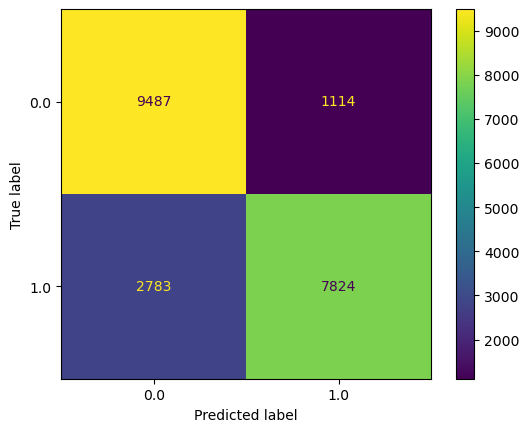

In [63]:
rf_conf_train = confusion_matrix(y_train, rf_train_pred)
rf_conf_test = confusion_matrix(y_test, rf_test_pred)

print(f'Random Forest Train Accuracy: {np.round(rf_train_score, 3)} & Test Accuracy: {np.round(rf_test_score, 3)}\n')

print(f'Train Confusion Matrix:\n{rf_conf_train}\n\nTest Confusion Matrix:\n{rf_conf_test}\n')
print(f'Train Classification Report:\n{classification_report(y_train, rf_train_pred)}\nTest Classification Report:\n{classification_report(y_test, rf_test_pred)}')

disp = ConfusionMatrixDisplay(rf_conf_test, display_labels = rf.classes_)
disp.plot()
plt.show()

## Logistic Regression Model Performance

Logisitc Regression Train Accuracy: 0.812 & Test Accuracy: 0.813

Train Confusion Matrix:
[[21878  2867]
 [ 6428 18311]]

Test Confusion Matrix:
[[9359 1242]
 [2729 7878]]

Train Classification Report:
              precision    recall  f1-score   support

         0.0       0.77      0.88      0.82     24745
         1.0       0.86      0.74      0.80     24739

    accuracy                           0.81     49484
   macro avg       0.82      0.81      0.81     49484
weighted avg       0.82      0.81      0.81     49484

Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.77      0.88      0.82     10601
         1.0       0.86      0.74      0.80     10607

    accuracy                           0.81     21208
   macro avg       0.82      0.81      0.81     21208
weighted avg       0.82      0.81      0.81     21208



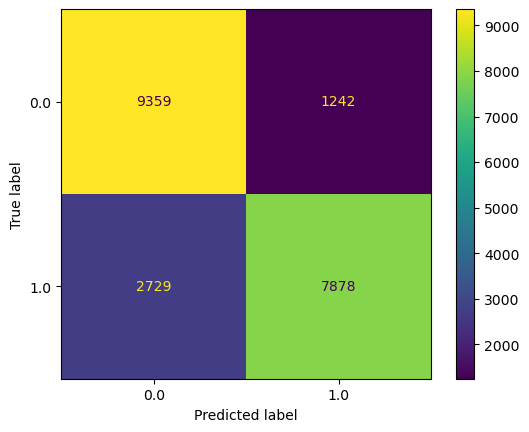

In [64]:
log_conf_train = confusion_matrix(y_train, log_train_pred)
log_conf_test = confusion_matrix(y_test, log_test_pred)

print(f'Logisitc Regression Train Accuracy: {np.round(log_train_score, 3)} & Test Accuracy: {np.round(log_test_score, 3)}\n')

print(f'Train Confusion Matrix:\n{log_conf_train}\n\nTest Confusion Matrix:\n{log_conf_test}\n')
print(f'Train Classification Report:\n{classification_report(y_train, log_train_pred)}\nTest Classification Report:\n{classification_report(y_test, log_test_pred)}')

disp = ConfusionMatrixDisplay(log_conf_test, display_labels = log.classes_)
disp.plot()
plt.show()

## SVM Model Performance

SVM Train Accuracy: 0.814 & Test Accuracy: 0.816

Train Confusion Matrix:
[[22039  2706]
 [ 6474 18265]]

Test Confusion Matrix:
[[9448 1153]
 [2746 7861]]

Train Classification Report:
              precision    recall  f1-score   support

         0.0       0.77      0.89      0.83     24745
         1.0       0.87      0.74      0.80     24739

    accuracy                           0.81     49484
   macro avg       0.82      0.81      0.81     49484
weighted avg       0.82      0.81      0.81     49484

Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.77      0.89      0.83     10601
         1.0       0.87      0.74      0.80     10607

    accuracy                           0.82     21208
   macro avg       0.82      0.82      0.82     21208
weighted avg       0.82      0.82      0.82     21208



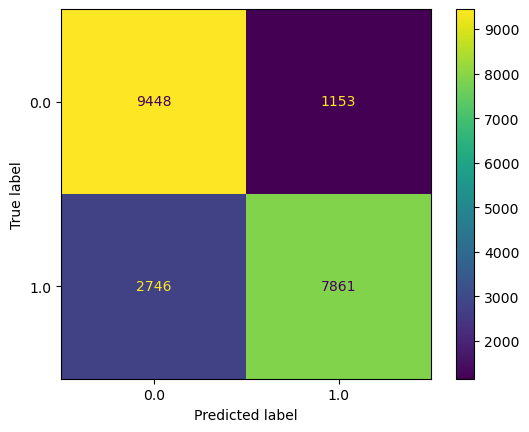

In [65]:
svm_conf_train = confusion_matrix(y_train, svm_train_pred)
svm_conf_test = confusion_matrix(y_test, svm_test_pred)

print(f'SVM Train Accuracy: {np.round(svm_train_score, 3)} & Test Accuracy: {np.round(svm_test_score, 3)}\n')

print(f'Train Confusion Matrix:\n{svm_conf_train}\n\nTest Confusion Matrix:\n{svm_conf_test}\n')
print(f'Train Classification Report:\n{classification_report(y_train, svm_train_pred)}\nTest Classification Report:\n{classification_report(y_test, svm_test_pred)}')

disp = ConfusionMatrixDisplay(svm_conf_test, display_labels = svm.classes_)
disp.plot()
plt.show()

# Creating DataFrame For Lasso Feature

In [34]:
X_selected_train = df_undersampled_train.loc[:, ['HighBP', 'BMI', 'Smoker','HeartDiseaseorAttack', 'HvyAlcoholConsump',
                                                 'GenHlth','MentHlth', 'PhysHlth', 'DiffWalk']]
print(X_selected_train.info())

X_selected_test = df_undersampled_test.loc[:, ['HighBP', 'BMI', 'Smoker','HeartDiseaseorAttack', 'HvyAlcoholConsump',
                                               'GenHlth','MentHlth', 'PhysHlth', 'DiffWalk']]
print(X_selected_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49484 entries, 0 to 49483
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   HighBP                49484 non-null  float64
 1   BMI                   49484 non-null  float64
 2   Smoker                49484 non-null  float64
 3   HeartDiseaseorAttack  49484 non-null  float64
 4   HvyAlcoholConsump     49484 non-null  float64
 5   GenHlth               49484 non-null  float64
 6   MentHlth              49484 non-null  float64
 7   PhysHlth              49484 non-null  float64
 8   DiffWalk              49484 non-null  float64
dtypes: float64(9)
memory usage: 3.4 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21208 entries, 0 to 21207
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   HighBP                21208 non-null  float64
 1   BMI                 

# Hyper Tuning Models Based Off Lasso Selection

## Perceptron Hyper Tuning With Lasso Features

In [35]:
gs_linear = GridSearchCV(estimator = Perceptron(),
                       param_grid = {'penalty': ['l2', 'l1', 'elasticnet', 'None'],
                                     'alpha': [0.0001, 0.001, 0.01, 1, 2],
                                    'early_stopping': [True, False],
                                    'random_state': [42]},
                       cv = 5,
                       scoring='accuracy',
                        verbose = 2,
                        n_jobs = -1)
gs_linear.fit(X_selected_train, y_train.values.ravel())

print(gs_linear.best_params_)
print(gs_linear.best_score_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
{'alpha': 0.0001, 'early_stopping': True, 'penalty': 'None', 'random_state': 42}
0.8209113774872291


## KNN Hyper Tuning With Lasso Features

In [36]:
gs = GridSearchCV(estimator=KNeighborsClassifier(),
                 param_grid = {'n_neighbors': range(3, 10, 1),
                              'weights': ['uniform', 'distance'],
                              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                              'p': [1, 2],
                              },
                 cv=5,
                 scoring='accuracy',
                 verbose = 3,
                 n_jobs = -1)
gs.fit(X_selected_train, y_train.values.ravel())

print(gs.best_params_)
print(gs.best_score_)

Fitting 5 folds for each of 112 candidates, totalling 560 fits
{'algorithm': 'auto', 'n_neighbors': 9, 'p': 2, 'weights': 'uniform'}
0.840898050649254


## Random Forest Hyper Tuning With Lasso Features

In [37]:
random_gs = GridSearchCV(estimator=RandomForestClassifier(),
                 param_grid = {'criterion': ['gini', 'entropy', 'log_loss'],
                              'min_samples_split': range(2, 22, 5),
                              'min_samples_leaf': range(2, 22, 5),
                              'max_features': ['sqrt', 'log2', 'auto'],
                              'random_state': [42],
                              'max_depth': range(5, 30, 5)},
                 cv=5,
                 scoring='accuracy',
                 verbose = 3,
                 n_jobs = -1)
random_gs.fit(X_selected_train, y_train.values.ravel())

print(random_gs.best_params_)
print(random_gs.best_score_)

Fitting 5 folds for each of 720 candidates, totalling 3600 fits


C:\Users\Felipe\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
1200 fits failed out of a total of 3600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1200 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Felipe\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Felipe\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 450, in fit
    trees = Parallel(
  File "C:\Users\Felipe\anaconda3\lib\site-packages\joblib\parallel.py", line 1863, in __call__
    return output if self.return_generator else list(output)
  File "C:\Users\Felipe\

{'criterion': 'entropy', 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 17, 'min_samples_split': 2, 'random_state': 42}
0.8555694101958335


## SVM Hyper Tuning With Lasso Features

In [41]:
svc_gs = GridSearchCV(estimator = SVC(),
                 param_grid = {'C': [0.1, 1, 5, 10],
                              'kernel': ['linear', 'poly', 'rbf'],
                              'degree': [3, 6, 9],
                              'gamma': ['scale', 'auto']},
                 cv = 5,
                 scoring = 'accuracy',
                     verbose = 3,
                     n_jobs = -1)
svc_gs.fit(X_selected_train, y_train.values.ravel())

print(svc_gs.best_params_)
print(svc_gs.best_score_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
{'C': 5, 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf'}
0.8524168744045889


## Logistic Regression Hyper Tuning

In [38]:
log_gs = GridSearchCV(estimator = LogisticRegression(),
                     param_grid = {'penalty': ['l1', 'l2', 'elasticnet', 'None'],
                                  'C': range(1, 10, 1),
                                  'random_state': [42],
                                  'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
                                  'l1_ratio': [0, 0.5, 1]},
                     cv=5,
                     scoring = 'accuracy',
                     verbose = 3,
                     n_jobs = -1)
log_gs.fit(X_selected_train, y_train)

print(log_gs.best_params_)
print(log_gs.best_score_)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits


C:\Users\Felipe\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
2160 fits failed out of a total of 3240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
135 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Felipe\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Felipe\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Felipe\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueEr

{'C': 8, 'l1_ratio': 0, 'penalty': 'l1', 'random_state': 42, 'solver': 'saga'}
0.8470616202994318


# Examining Performance of Lasso Models

In [42]:
knn = KNeighborsClassifier(algorithm = 'auto', n_neighbors = 9, p = 2, weights = 'uniform')
knn.fit(X_selected_train, y_train.values.ravel())
knn_train_pred = knn.predict(X_selected_train)
knn_train_score = accuracy_score(y_train, knn_train_pred)
knn_test_pred = knn.predict(X_selected_test)
knn_test_score = accuracy_score(y_test, knn_test_pred)

print(f'KNN Train Accuracy: {np.round(knn_train_score, 3)} & Test Accuracy: {np.round(knn_test_score, 3)}')

rf = RandomForestClassifier(criterion = 'entropy',max_features = 'sqrt', max_depth = 15, min_samples_split = 2,min_samples_leaf=17, random_state=42)
rf.fit(X_selected_train, y_train.values.ravel())
rf_train_pred = rf.predict(X_selected_train)
rf_train_score = accuracy_score(y_train, rf_train_pred)
rf_test_pred = rf.predict(X_selected_test)
rf_test_score = accuracy_score(y_test, rf_test_pred)

print(f'Random Forest Tree Train Accuracy: {np.round(rf_train_score, 3)} & Test Accuracy: {np.round(rf_test_score, 3)}')

line = Perceptron(alpha = 0.0001, early_stopping = True, penalty = None, random_state=42)
line.fit(X_selected_train, y_train.values.ravel())
line_train_pred = line.predict(X_selected_train)
line_train_score = accuracy_score(y_train, line_train_pred)
line_test_pred = line.predict(X_selected_test)
line_test_score = accuracy_score(y_test, line_test_pred)

print(f'Linear Classifier/Perceptron Train Accuracy: {np.round(line_train_score, 3)} & Test Accuracy: {np.round(line_test_score, 3)}')

svm = SVC(C = 5, degree = 3, gamma = 'auto', kernel = 'rbf')
svm.fit(X_selected_train, y_train.values.ravel())
svm_train_pred = svm.predict(X_selected_train)
svm_train_score = accuracy_score(y_train, svm_train_pred)
svm_test_pred = svm.predict(X_selected_test)
svm_test_score = accuracy_score(y_test, svm_test_pred)

print(f'SVM Train Accuracy: {np.round(svm_train_score, 3)} & Test Accuracy: {np.round(svm_test_score, 3)}')

log = LogisticRegression(C = 8, l1_ratio = 0, penalty = 'l1', random_state=42, solver = 'saga')
log.fit(X_selected_train, y_train.values.ravel())
log_train_pred = log.predict(X_selected_train)
log_train_score = accuracy_score(y_train, log_train_pred)
log_test_pred = log.predict(X_selected_test)
log_test_score = accuracy_score(y_test, log_test_pred)

print(f'Logistic Regression Train Accuracy: {np.round(log_train_score, 3)} & Test Accuracy: {np.round(log_test_score, 3)}')

C:\Users\Felipe\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Felipe\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepd

KNN Train Accuracy: 0.851 & Test Accuracy: 0.841
Random Forest Tree Train Accuracy: 0.857 & Test Accuracy: 0.852
Linear Classifier/Perceptron Train Accuracy: 0.766 & Test Accuracy: 0.763
SVM Train Accuracy: 0.854 & Test Accuracy: 0.85


C:\Users\Felipe\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


Logistic Regression Train Accuracy: 0.847 & Test Accuracy: 0.845


# Closer Look At The Top 3 Performing Models For Lasso

# Random Forest Model Performance

    * Created confusion matrix visual for the test data

Random Forest Train Accuracy: 0.857 & Test Accuracy: 0.852

Train Confusion Matrix:
[[22938  1807]
 [ 5261 19478]]

Test Confusion Matrix:
[[9759  842]
 [2295 8312]]

Train Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      0.93      0.87     24745
         1.0       0.92      0.79      0.85     24739

    accuracy                           0.86     49484
   macro avg       0.86      0.86      0.86     49484
weighted avg       0.86      0.86      0.86     49484

Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      0.92      0.86     10601
         1.0       0.91      0.78      0.84     10607

    accuracy                           0.85     21208
   macro avg       0.86      0.85      0.85     21208
weighted avg       0.86      0.85      0.85     21208



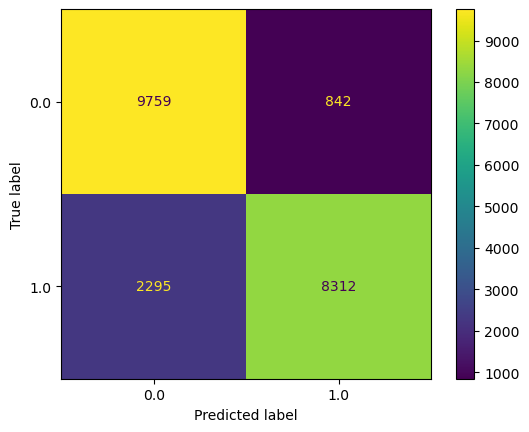

In [51]:
rf_conf_train = confusion_matrix(y_train, rf_train_pred)
rf_conf_test = confusion_matrix(y_test, rf_test_pred)

print(f'Random Forest Train Accuracy: {np.round(rf_train_score, 3)} & Test Accuracy: {np.round(rf_test_score, 3)}\n')

print(f'Train Confusion Matrix:\n{rf_conf_train}\n\nTest Confusion Matrix:\n{rf_conf_test}\n')
print(f'Train Classification Report:\n{classification_report(y_train, rf_train_pred)}\nTest Classification Report:\n{classification_report(y_test, rf_test_pred)}')

disp = ConfusionMatrixDisplay(rf_conf_test, display_labels = rf.classes_)
disp.plot()
plt.show()

# SVM Forest Model Performance

    * I went ahead and created a better visual for the test datas confusion matrix

SVM Train Accuracy: 0.854 & Test Accuracy: 0.85

Train Confusion Matrix:
[[23479  1266]
 [ 5951 18788]]

Test Confusion Matrix:
[[10027   574]
 [ 2598  8009]]

Train Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.95      0.87     24745
         1.0       0.94      0.76      0.84     24739

    accuracy                           0.85     49484
   macro avg       0.87      0.85      0.85     49484
weighted avg       0.87      0.85      0.85     49484

Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.79      0.95      0.86     10601
         1.0       0.93      0.76      0.83     10607

    accuracy                           0.85     21208
   macro avg       0.86      0.85      0.85     21208
weighted avg       0.86      0.85      0.85     21208



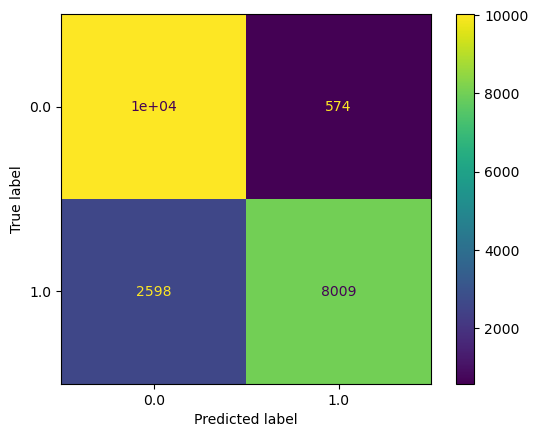

In [50]:
svm_conf_train = confusion_matrix(y_train, svm_train_pred)
svm_conf_test = confusion_matrix(y_test, svm_test_pred)

print(f'SVM Train Accuracy: {np.round(svm_train_score, 3)} & Test Accuracy: {np.round(svm_test_score, 3)}\n')

print(f'Train Confusion Matrix:\n{svm_conf_train}\n\nTest Confusion Matrix:\n{svm_conf_test}\n')
print(f'Train Classification Report:\n{classification_report(y_train, svm_train_pred)}\nTest Classification Report:\n{classification_report(y_test, svm_test_pred)}')

disp = ConfusionMatrixDisplay(svm_conf_test, display_labels = svm.classes_)
disp.plot()
plt.show()

# Logistic Regression Model Performance
    * I went ahead and created a better visual for the test datas confusion matrix

Logisitc Regression Train Accuracy: 0.847 & Test Accuracy: 0.845

Train Confusion Matrix:
[[22649  2096]
 [ 5475 19264]]

Test Confusion Matrix:
[[9649  952]
 [2339 8268]]

Train Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      0.92      0.86     24745
         1.0       0.90      0.78      0.84     24739

    accuracy                           0.85     49484
   macro avg       0.85      0.85      0.85     49484
weighted avg       0.85      0.85      0.85     49484

Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.91      0.85     10601
         1.0       0.90      0.78      0.83     10607

    accuracy                           0.84     21208
   macro avg       0.85      0.84      0.84     21208
weighted avg       0.85      0.84      0.84     21208



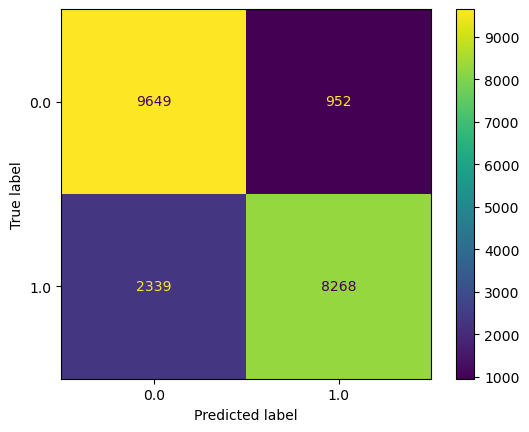

In [49]:
log_conf_train = confusion_matrix(y_train, log_train_pred)
log_conf_test = confusion_matrix(y_test, log_test_pred)

print(f'Logisitc Regression Train Accuracy: {np.round(log_train_score, 3)} & Test Accuracy: {np.round(log_test_score, 3)}\n')

print(f'Train Confusion Matrix:\n{log_conf_train}\n\nTest Confusion Matrix:\n{log_conf_test}\n')
print(f'Train Classification Report:\n{classification_report(y_train, log_train_pred)}\nTest Classification Report:\n{classification_report(y_test, log_test_pred)}')

disp = ConfusionMatrixDisplay(log_conf_test, display_labels = log.classes_)
disp.plot()
plt.show()

# Results

* The best performing model was the Random Forest for both feature selection methods
    * Out of the two feature selection methods, LassoCV gave the best results
    
    
* With the two different feature selection methods, the top 3 models stayed the same
    * The top three performing models were Random Forest, SVM and Logistic Regression (In that order)
    
    
* In addition we can look at both feature selection methods
    * Overall, LassoCV has created the best results for all models
    
    
* Model That I am going to use for the remainder of the project is going to be as follows:
    * The LassoCV selection methods as it yielded the best results overall
    * The Random Forest Model as in both selection methods, it performed the best